# 4. Generating mock data

This notebook shows how the supernova data is generated.  You don't actually need to use this, it's just here to show you how it is done.


### 4.1. First set the constants and load packages.

In [8]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from numpy.random import default_rng as rand

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc

### 4.2. Then write the functions we'll need.

We need to know the distance modulus as a function of redshift.  Distance modulus is defined as 
\begin{equation} \mu(z) = 5 \log_{10}(D_L)\end{equation}
where
\begin{equation} D_L = R_0 S_k(\chi) (1+z) \end{equation}
and $S_k(\chi)=\sin(\chi), \chi,\; {\rm or}\; \sinh(\chi)$ for closed, flat, and open universes respectively, and
\begin{equation} \chi = \frac{c}{R_0H_0}\int_0^z \frac{dz}{E(z)}\end{equation}
with $E(z)=H(z)/H_0$.

In [178]:
# Write a function for the integrand, i.e. $1/E(z)$,
def ezinv(z,om=0.3,ox=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ok = 1.-om-ox-orr
    ### CODE HERE HIDDEN ###
    return 1./ez

def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

def dist_mod(zs,om=0.3,ox=0.7,w0=-1.0,wa=0.0,orr=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - ox
    xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ox, w0, wa, orr))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod

In [198]:
### Define the cosmological model!  (This will change for each data set you want to generate.)

om=0.3  # Matter density
ox=0.7  # Dark Energy density
orr=0.0 # Radiation density
w0=-1.0 # Dark Energy equation of state
wa=-0.0  # Linear change with scalefactor of dark energy equation of state

model_name='Data0'

### 4.3. Now generate some perfect data according to the theory.

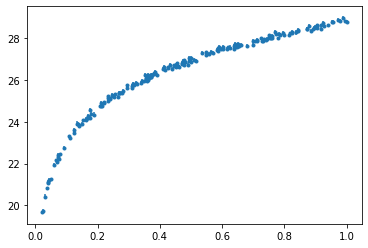

0.06945931006937488


In [199]:
# Generate some random redshifts between 0.02 < z < 1.0.
rng = np.random.default_rng(seed=3080) # initiate random number generator
zs = rng.random(200) # Make 100 random numbers between 0 and 1
zs = np.sort(zs) # Sort them in ascending order (just for simplicity)
zs = zs[np.where(zs > 0.02)] # Reject very low-redshifts. 

# Generate the corresponding distance moduli 
muperfect = dist_mod(zs, om=om, ox=ox, w0=w0, wa=wa, orr=orr)

# Add error bars (they'll all be around muerr of 0.1, but with a scatter of about 0.05)
muerr = 0.08+(rng.random(len(zs))-0.5)*0.05

# Add scatter according to the size of the error bars
muscatter = rng.standard_normal(len(zs))*muerr
mu = muperfect+muscatter

# Plot as a sanity check
plt.errorbar(zs,mu,yerr=muerr,fmt='.')
plt.show()

### 4.4 Print file with data AND separate file saving the inputs

In [200]:
data = np.zeros((len(zs),3)) # Set up an array with a row for each data point and 3 columns
data[:,0]=zs
data[:,1]=mu
data[:,2]=muerr

np.savetxt('data/'+model_name+'.txt', data, delimiter=',', fmt='%.6f, %.4f, %.4f', newline='\n', header=model_name+'\nzs, mu, muerr', comments='# ')

with open('data/'+model_name+'_solutions.txt', 'w') as f:
    f.write('Solutions for '+model_name+':\n')
    f.write('Omega M = %.2f\n'%om)
    f.write('Omega X = %.2f\n'%ox)
    f.write('Omega R = %.2f\n'%orr)
    f.write('w0 = %.2f\n'%w0)
    f.write('wa = %.2f'%wa)
    f.close()

### 4.5 This is a function that will read in that data

In [151]:
def read_data(model_name):
    d = np.genfromtxt(model_name+'.txt',delimiter=',')
    zs = d[:,0]
    mu = d[:,1]
    muerr=d[:,2]
    return zs, mu, muerr

zs, mu, muerr = read_data(model_name)